In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [59]:
def generate_burnout_data(n, balanced=False):
    mean = 1
    std_dev = 2

    responses_list = []
    burnout_indices = []

    for _ in range(n):
        responses = np.random.normal(mean, std_dev, 22)
        responses = np.clip(np.round(responses), 0, 6).astype(int)

        ee_questions = [0, 1, 2, 7, 12, 13, 15, 19]
        dp_questions = [4, 9, 10, 14, 21]
        pa_questions = [3, 6, 8, 11, 16, 17, 18, 20]

        ee_score = responses[ee_questions].sum()
        dp_score = responses[dp_questions].sum()
        ee_score += (6 - responses[5])
        pa_score = responses[pa_questions].sum()

        burnout_index = np.sqrt(
            ((ee_score / 54) ** 2 +
             (dp_score / 30) ** 2 +
             ((1 - pa_score / 48)) ** 2) / 3
        )

        responses_list.append(responses)
        burnout_indices.append(burnout_index)

    burnout_indices = np.array(burnout_indices)

    if not balanced:
        labels = []
        for bi in burnout_indices:
            if bi >= 0.55:
                label = 2
            elif bi >= 0.45 and bi < 0.55:
                label = 1
            else:
                label = 0
            labels.append(label)
        labels = np.array(labels)
    else:
        order = np.argsort(burnout_indices)
        labels = np.empty(n, dtype=int)

        n0 = n // 3
        n1 = 2 * n // 3

        labels[order[:n0]] = 0
        labels[order[n0:n1]] = 1
        labels[order[n1:]] = 2

    rows = []
    for i in range(n):
        row = list(responses_list[i]) + [burnout_indices[i], labels[i]]
        rows.append(row)

    columns = [f'Q{i+1}' for i in range(22)] + ['burnout_index', 'label']
    df = pd.DataFrame(rows, columns=columns)
    return df

In [66]:
np.random.seed(42) 
n = 100000
df = generate_burnout_data(n, balanced=True)

df.to_csv('burnout_test_data.csv', index=False, encoding='utf-8')
print(df.head())

   Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q15  Q16  Q17  Q18  Q19  Q20  \
0   2   1   2   4   1   1   4   3   0    2  ...    0    0    0    2    0    0   
1   1   0   0   1   0   2   0   0   0    5  ...    1    0    0    1    2    1   
2   0   0   0   3   2   0   2   0   0    2  ...    2    3    0    1    0    0   
3   1   3   2   0   2   4   1   4   0    3  ...    1    2    4    0    0    0   
4   0   2   1   3   0   0   0   0   2    2  ...    0    0    1    2    5    1   

   Q21  Q22  burnout_index  label  
0    4    1       0.442240      0  
1    1    0       0.543059      2  
2    3    4       0.509266      1  
3    3    2       0.535912      2  
4    2    1       0.406823      0  

[5 rows x 24 columns]


In [80]:
def load_and_prepare_data(filename):
    df = pd.read_csv(filename)

    X = df.drop(['label'], axis=1)
    y = df['label']
    metric = df['burnout_index']

    print(f"Размерность данных (X): {X.shape}")
    print("Распределение классов:")
    class_counts = y.value_counts().sort_index()
    for cls, cnt in class_counts.items():
        print(f"  Класс {cls}: {cnt} ({cnt / len(y):.2%})")

    any_burnout = (y > 0).mean()
    strong_burnout = (y == 2).mean()
    print(f"Процент любого выгорания (1 или 2): {any_burnout:.2%}")
    print(f"Процент сильного выгорания (2): {strong_burnout:.2%}")

    # Краткая сводка по интегральной метрике
    print("\nИНТЕГРАЛЬНАЯ МЕТРИКА (burnout_index):")
    print(f"  Среднее: {metric.mean():.4f}")
    print(f"  Минимум: {metric.min():.4f}")
    print(f"  Максимум: {metric.max():.4f}")

    return X, y


def train_and_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        random_state=2025,
        max_iter=200,
        class_weight='balanced',
        solver='lbfgs'
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    return model, scaler, X_test, y_test, y_pred, y_pred_proba

def plot_metrics(y_test, y_pred, y_pred_proba, model):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Матрица ошибок (3x3)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Матрица ошибок')
    axes[0, 0].set_xlabel('Предсказанный класс')
    axes[0, 0].set_ylabel('Истинный класс')

    # ROC-кривая для сильного выгорания (класс 2 против остальных)
    if 2 in model.classes_:
        idx_high = list(model.classes_).index(2)
        y_test_high = (y_test == 2).astype(int)
        y_proba_high = y_pred_proba[:, idx_high]

        fpr, tpr, thresholds = roc_curve(y_test_high, y_proba_high)
        roc_auc_high = roc_auc_score(y_test_high, y_proba_high)

        axes[0, 1].plot(fpr, tpr, lw=2,
                        label=f'ROC (AUC = {roc_auc_high:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], lw=2, linestyle='--')
        axes[0, 1].set_xlim([0.0, 1.0])
        axes[0, 1].set_ylim([0.0, 1.05])
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC-кривая для сильного выгорания (класс 2)')
        axes[0, 1].legend(loc="lower right")
    else:
        axes[0, 1].text(0.5, 0.5,
                        'Класс 2 отсутствует в данных\nROC-кривая не построена',
                        ha='center', va='center')
        axes[0, 1].set_axis_off()

    coefs = model.coef_
    feature_importance = np.mean(np.abs(coefs), axis=0)

    n_features = coefs.shape[1]
    if n_features == 22:
        feature_names = [f'Q{i+1}' for i in range(22)]
    elif n_features == 23:
        feature_names = [f'Q{i+1}' for i in range(22)] + ['burnout_index']
    else:
        feature_names = [f'X{i+1}' for i in range(n_features)]

    indices = np.argsort(feature_importance)[::-1]

    if len(indices) > 0:
        idx_top = indices[0]
        filtered_indices = indices[1:]
    else:
        filtered_indices = indices

    axes[1, 0].bar(range(len(filtered_indices)),
                   feature_importance[filtered_indices])
    axes[1, 0].set_title('Важность признаков (без самого доминирующего)')
    axes[1, 0].set_xlabel('Признаки')
    axes[1, 0].set_ylabel('Важность')
    axes[1, 0].set_xticks(range(len(filtered_indices)))
    axes[1, 0].set_xticklabels([feature_names[i] for i in filtered_indices],
                               rotation=45)

    if 2 in model.classes_:
        idx_high = list(model.classes_).index(2)
        y_test_high = (y_test == 2).astype(int)
        y_proba_high = y_pred_proba[:, idx_high]

        axes[1, 1].hist(
            [y_proba_high[y_test_high == 0],
             y_proba_high[y_test_high == 1]],
            bins=20, alpha=0.7,
            label=['Нет сильного выгорания (0 или 1)', 'Сильное выгорание (2)']
        )
        axes[1, 1].set_title('Распределение вероятностей сильного выгорания (класс 2)')
        axes[1, 1].set_xlabel('Вероятность сильного выгорания')
        axes[1, 1].set_ylabel('Частота')
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5,
                        'Класс 2 отсутствует в данных\nгистограмма не построена',
                        ha='center', va='center')
        axes[1, 1].set_axis_off()
    
    plt.tight_layout()
    plt.show()

Размерность данных (X): (100000, 23)
Распределение классов:
  Класс 0: 33333 (33.33%)
  Класс 1: 33333 (33.33%)
  Класс 2: 33334 (33.33%)
Процент любого выгорания (1 или 2): 66.67%
Процент сильного выгорания (2): 33.33%

ИНТЕГРАЛЬНАЯ МЕТРИКА (burnout_index):
  Среднее: 0.4994
  Минимум: 0.2386
  Максимум: 0.7191

Обучение модели...

МЕТРИКИ МОДЕЛИ (3 класса)
Точность (Accuracy): 0.9954
Точность (Precision, weighted): 0.9955
Полнота (Recall, weighted): 0.9954
F1-мера (weighted): 0.9955
ROC-AUC для сильного выгорания (класс 2): 1.0000

ОТЧЕТ КЛАССИФИКАЦИИ
                         precision    recall  f1-score   support

      Нет выгорания (0)       1.00      1.00      1.00      6667
Умеренное выгорание (1)       0.99      0.99      0.99      6666
  Сильное выгорание (2)       1.00      1.00      1.00      6667

               accuracy                           1.00     20000
              macro avg       1.00      1.00      1.00     20000
           weighted avg       1.00      1.00    

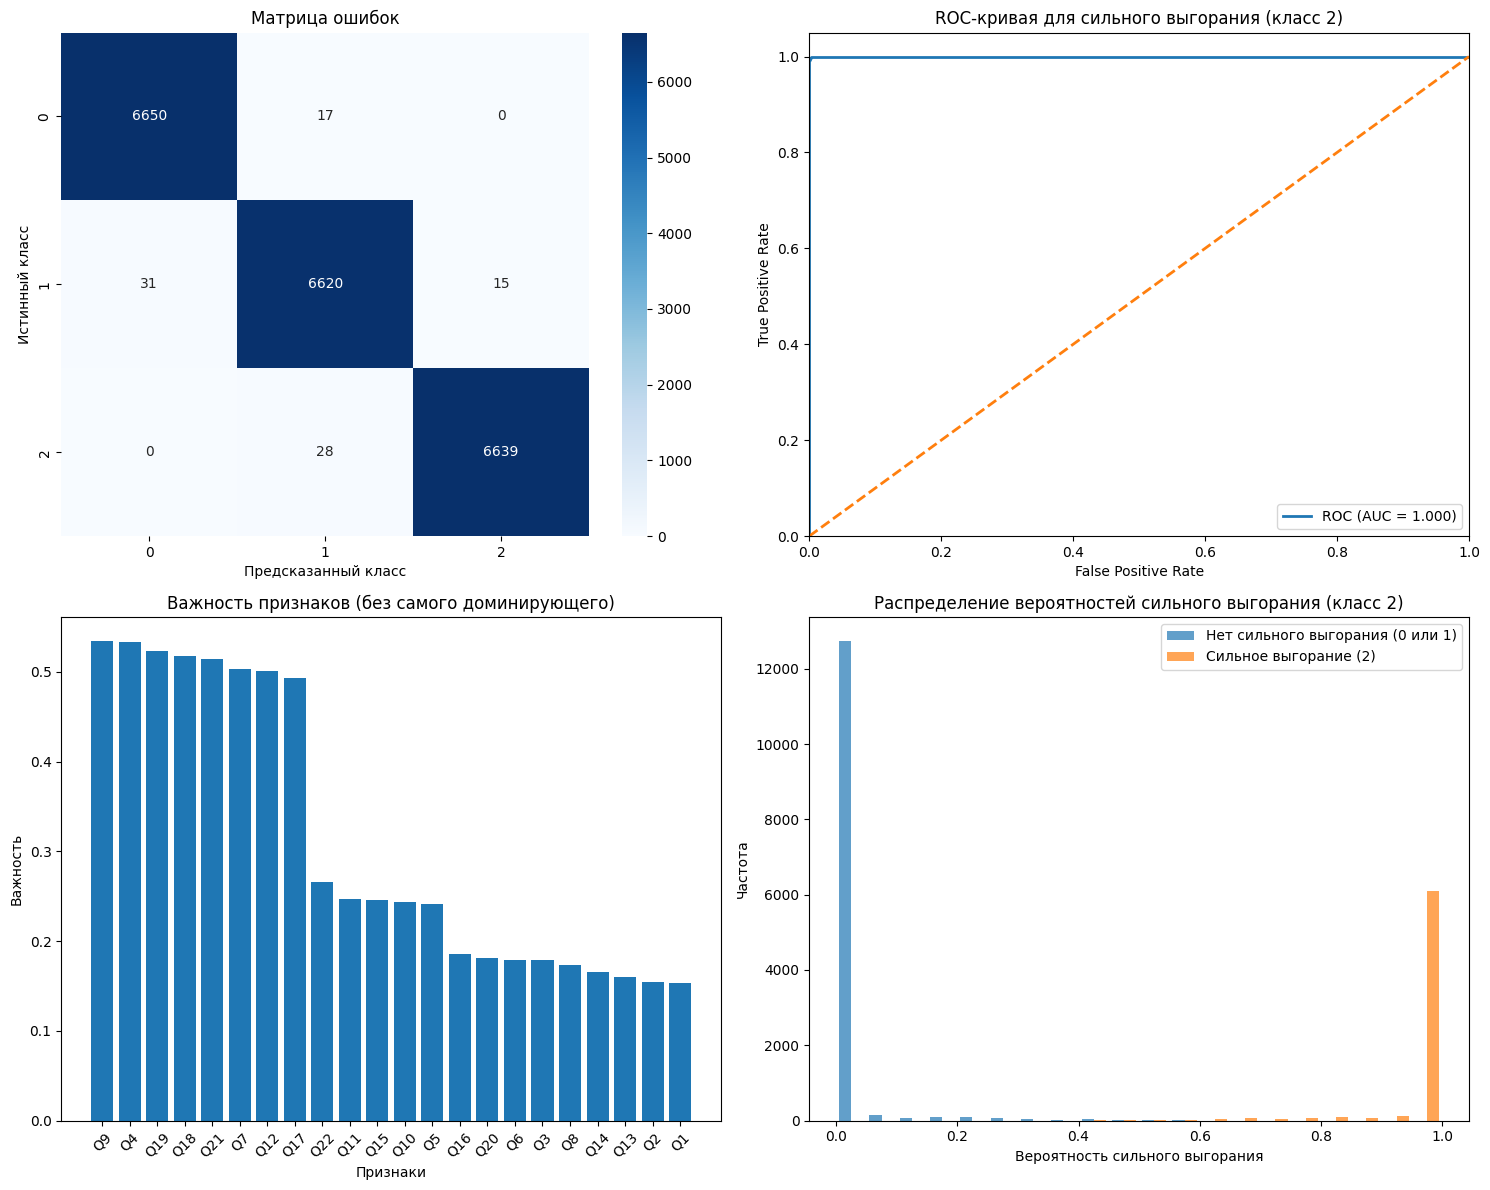


ТОП-10 ВАЖНЕЙШИХ ВОПРОСОВ
Вопрос  Важность
    Q9  0.534456
    Q4  0.532844
   Q19  0.522785
   Q18  0.517688
   Q21  0.514236
    Q7  0.502770
   Q12  0.501100
   Q17  0.492779
   Q22  0.266223
   Q11  0.247312

Модель и скейлер сохранены в 'burnout_model.pkl' и 'burnout_scaler.pkl'.


In [ ]:
def main():
    X, y = load_and_prepare_data('burnout_test_data.csv')
    print("\nОбучение модели...")
    model, scaler, X_test, y_test, y_pred, y_pred_proba = train_and_evaluate_model(X, y)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("\n" + "="*50)
    print("МЕТРИКИ МОДЕЛИ (3 класса)")
    print("="*50)
    print(f"Точность (Accuracy): {accuracy:.4f}")
    print(f"Точность (Precision, weighted): {precision:.4f}")
    print(f"Полнота (Recall, weighted): {recall:.4f}")
    print(f"F1-мера (weighted): {f1:.4f}")

    if 2 in model.classes_:
        idx_high = list(model.classes_).index(2)
        y_test_high = (y_test == 2).astype(int)
        y_proba_high = y_pred_proba[:, idx_high]
        roc_auc_high = roc_auc_score(y_test_high, y_proba_high)
        print(f"ROC-AUC для сильного выгорания (класс 2): {roc_auc_high:.4f}")
    else:
        print("ROC-AUC: класс 2 не встречался в обучении, метрику посчитать нельзя.")

    print("\n" + "="*50)
    print("ОТЧЕТ КЛАССИФИКАЦИИ")
    print("="*50)
    print(classification_report(
        y_test, 
        y_pred,
        labels=[0, 1, 2],
        target_names=[
            'Нет выгорания (0)',
            'Умеренное выгорание (1)',
            'Сильное выгорание (2)'
        ],
        zero_division=0
    ))

    print("\nВизуализация метрик...")
    plot_metrics(y_test, y_pred, y_pred_proba, model)

    print("\n" + "="*50)
    print("ТОП-10 ВАЖНЕЙШИХ ВОПРОСОВ")
    print("="*50)
    
    coefs = model.coef_
    feature_importance = np.mean(np.abs(coefs), axis=0)
    feature_names = [f'Q{i+1}' for i in range(23)]
    importance_df = pd.DataFrame({
        'Вопрос': feature_names,
        'Важность': feature_importance,
    }).sort_values('Важность', ascending=False)
    importance_df.drop(index=importance_df.index[0], axis=0, inplace=True)
    
    print(importance_df.head(10).to_string(index=False))
    
    joblib.dump(model, 'burnout_model.pkl')
    joblib.dump(scaler, 'burnout_scaler.pkl')
    print("\nМодель и скейлер сохранены в 'burnout_model.pkl' и 'burnout_scaler.pkl'.")


if __name__ == "__main__":
    main()